## Graph Classification


In [1]:
# !pip install torch-scatter
# !pip install torch-geometric
# !pip install torch-sparse==0.6.13 -f https://pytorch-geometric.com/whl/torch-1.10.0+cu113.html

In [2]:
import copy
import torch
from torch_geometric.nn import global_mean_pool, GCNConv, GINConv
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

Hyperparameters:

In [3]:
EPOCHS = 100
HIDDEN_DIM = 64
LEARN_RATE = 0.01
BATCH_SIZE = 1

Load dataset:

In [4]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG',
transform=NormalizeFeatures())
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
train_dataset = dataset[: int(len(dataset) * 0.8)]
test_dataset = dataset[int(len(dataset) * 0.8): ]
print('==== train_dataset =====')
print(train_dataset)
print('==== test_dataset =====')
print(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2
==== train_dataset =====
MUTAG(150)
==== test_dataset =====
MUTAG(38)


Network architecture:

In [5]:
class GIN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        nn1 = torch.nn.Sequential(
            torch.nn.Linear(dataset.num_features, HIDDEN_DIM)
        )
        nn2 = torch.nn.Sequential(
            torch.nn.Linear(HIDDEN_DIM, dataset.num_classes)
        )
        self.conv1 = GINConv(nn1)
        self.conv2 = GINConv(nn2)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, data.batch)
        return x

Train and test:

In [6]:
model = GIN()
optimizer = torch.optim.Adam(list(model.parameters()), lr=LEARN_RATE)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    cum_loss = 0
    for data in train_loader:
        pred = model(data)
        loss = criterion(pred, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        cum_loss += loss
    return cum_loss / len(train_loader) # accuracy

def test(loader):
     model.eval()
     correct = 0
     for data in loader:
         pred = model(data)
         correct += (pred.argmax(dim=1) == data.y).sum()
     return correct / len(loader.dataset) # accuracy

# dictionary to keep track of losses and accuracies
H = {
	'train_loss': [],
	'train_acc': [],
	'test_acc': [],
    'train_err': [],
	'test_err': [],
}

for epoch in tqdm(range(1, EPOCHS+1), desc='Training:'):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    H['train_loss'].append(train_loss.item())
    H['train_acc'].append(train_acc)
    H['test_acc'].append(test_acc)
    H['train_err'].append(1-train_acc)
    H['test_err'].append(1-test_acc)

Training::   0%|          | 0/100 [00:00<?, ?it/s]

Plotting results:

C:\Users\Omer\AppData\Local\Temp\ipykernel_26500\4034718359.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


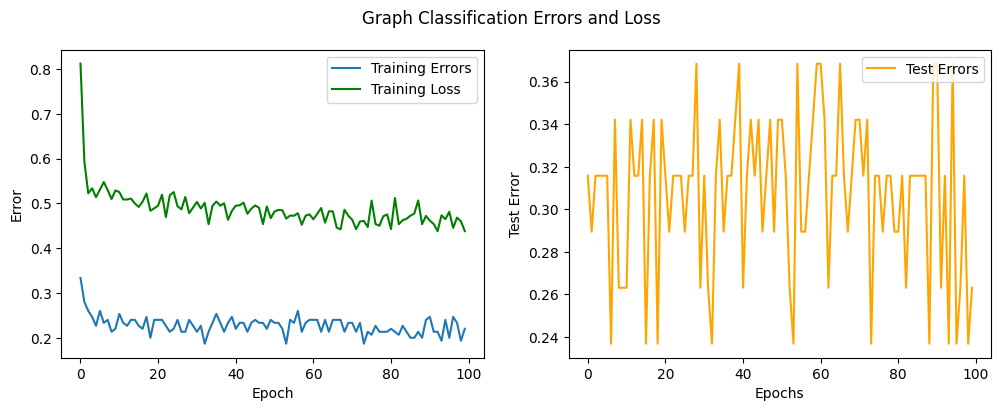

In [7]:
fig = plt.figure(figsize=(12, 4))

sub1 = fig.add_subplot(121)
sub1.plot(H['train_err'], label='Training Errors')
sub1.plot(H['train_loss'], label='Training Loss', color='green')
sub1.set_xlabel('Epoch')
sub1.set_ylabel('Error')
sub1.legend(loc='upper right')

sub2 = fig.add_subplot(122)
sub2.plot(H['test_err'], label='Test Errors', color='orange')
sub2.set_xlabel('Epochs')
sub2.set_ylabel('Test Error')
sub2.legend(loc='upper right')

fig.suptitle('Graph Classification Errors and Loss')
fig.show()